<a href="https://colab.research.google.com/github/Axeloooo/pytorch/blob/main/03_pytorch_computer_vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 03. PyTorch Computer Vision

## 0. Computer vision libraries in PyTorch

* `torchvision` - base domain libary for PyTorch computer vision
* `torchvision.datasets` - get datasets and data loading functions for computer vision
* `torchvision.model` - get pretrained computer vision models that you can leverage for your own problems
* `torchvision.transforms` - functions for manipulating yoru vision data (images) to be suitable for use with a ML model
* `torch.utils.data.Dataset` - base dataset class for PyTorch
* `torch.utils.data.DataLoader` - creates a Python iterable over a dataset

In [ ]:
# Import PyTorch
import torch
from torch import nn

# Import torchvision
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

# Import matplotlib for visualization
import matplotlib.pyplot as plt

# Check versions
print(torch.__version__)
print(torchvision.__version__)

2.6.0+cu124
0.21.0+cu124


## 1. Getting a dataset

 The dataset we'll be using is FashionMNIST from torchvision.datasets

In [ ]:
# Setup training data
train_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

# Setup testing data
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

In [ ]:
len(train_data), len(test_data)

(60000, 10000)

In [ ]:
# See the first training example
image, label = train_data[0]
image, label

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0039, 0.0000, 0.0000, 0.0510,
           0.2863, 0.0000, 0.0000, 0.0039, 

In [ ]:
class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [ ]:
# Check the shape of our image
image.shape, label

(torch.Size([1, 28, 28]), 9)

## 1.1 Check input and output shapes of data

In [ ]:
# Check the shape of our image
print(f"Image sahpe: {image.shape} -> [color_channels, height, width]")
print(f"Image label: {class_names[label]}")

Image sahpe: torch.Size([1, 28, 28]) -> [color_channels, height, width]
Image label: Ankle boot


# 1.2 Visualize our data

Text(0.5, 1.0, '9')

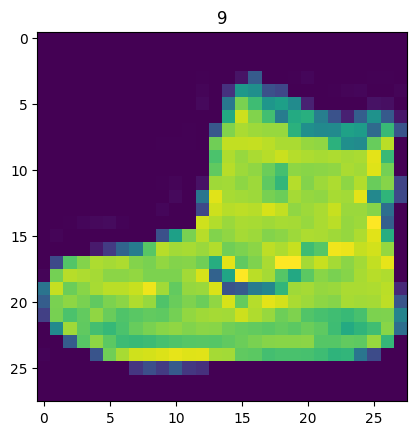

In [ ]:
plt.imshow(image.squeeze())
plt.title(label)

(np.float64(-0.5), np.float64(27.5), np.float64(27.5), np.float64(-0.5))

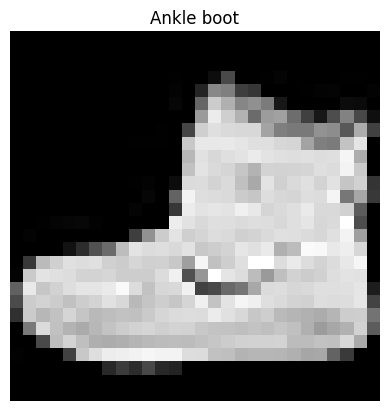

In [ ]:
plt.imshow(image.squeeze(), cmap="gray")
plt.title(class_names[label])
plt.axis(False)

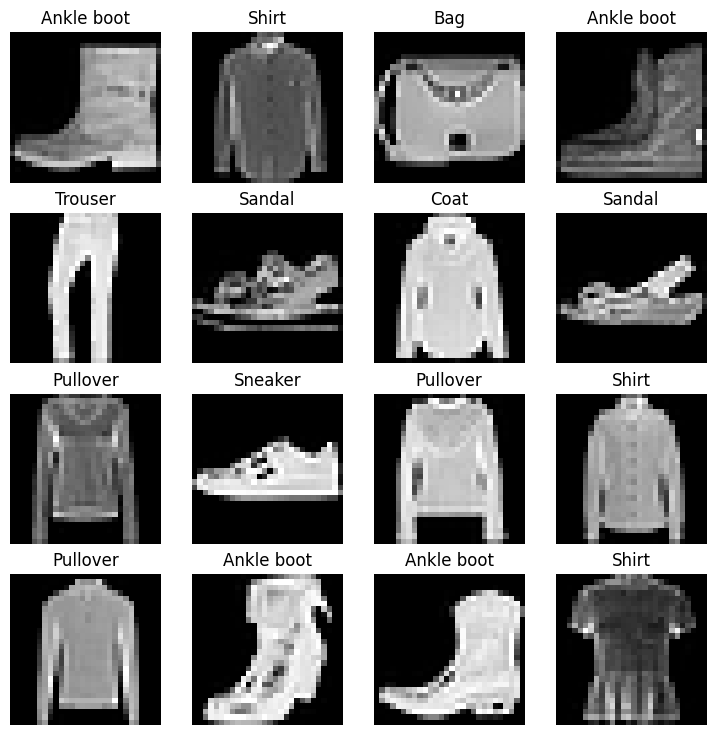

In [ ]:
# Plot more images
torch.manual_seed(42)
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows*cols+1):
  random_idx = torch.randint(0, len(train_data), size=[1]).item()
  img, label = train_data[random_idx]
  fig.add_subplot(rows, cols, i)
  plt.imshow(img.squeeze(), cmap="gray")
  plt.title(class_names[label])
  plt.axis(False)

In [ ]:
train_data, test_data

(Dataset FashionMNIST
     Number of datapoints: 60000
     Root location: data
     Split: Train
     StandardTransform
 Transform: ToTensor(),
 Dataset FashionMNIST
     Number of datapoints: 10000
     Root location: data
     Split: Test
     StandardTransform
 Transform: ToTensor())

## 2. Prepare DataLoader

Right now, our data is in the form of PyTorch Datasets.

DataLoader, turns our dataset into a Python iterable.

More specifically, we want to turn our data into batches (or mini-batches)

Why would we do this?

1. It is more computationally efficient, as in, your computer hardware may not be able to look (store in memory) at 60000 images in one hit. So we break it down to 32 images at a time (batch size of 32).
2. It gives our neural network more chances to update its gradient per epoch.

In [ ]:
from torch.utils.data import DataLoader

# Setup the batch size hyperparameter
BATCH_SIZE = 32

# Turn datasets into iterables (batches)
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x78f9f1a2e7d0>,
 <torch.utils.data.dataloader.DataLoader at 0x78f9f24d3810>)

In [ ]:
# Let's check out what we've created
print(f"DataLoaders: {train_dataloader, test_dataloader}")
print(f"Length of train_dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test_dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")

DataLoaders: (<torch.utils.data.dataloader.DataLoader object at 0x78f9f1a2e7d0>, <torch.utils.data.dataloader.DataLoader object at 0x78f9f24d3810>)
Length of train_dataloader: 1875 batches of 32
Length of test_dataloader: 313 batches of 32


In [ ]:
# Check out what's inside the training dataloader
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

Image size: torch.Size([1, 28, 28])
Label: 6, label size: torch.Size([])


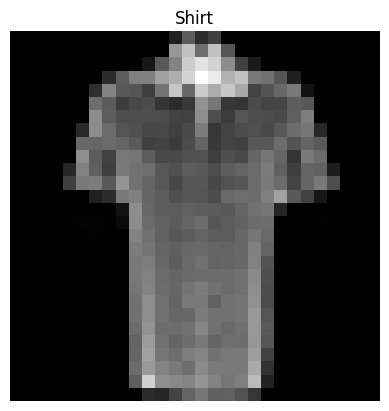

In [ ]:
# Show a sample
torch.manual_seed(42)
random_idx = torch.randint(0, len(train_features_batch), size=[1]).item()
img, label = train_features_batch[random_idx], train_labels_batch[random_idx]
plt.imshow(img.squeeze(), cmap="gray")
plt.title(class_names[label])
plt.axis(False)
print(f"Image size: {img.shape}")
print(f"Label: {label}, label size: {label.shape}")

## 3. Model 0: Build a baseline model

When starting to build a series of machine learning modelling experiments, it's best practice to start with a baseline model.

A baseline model is a simple model you will try to  imporve upon with subsequent models/experiments.

In other words: start simply and add complexity when necessary.

In [ ]:
# Create a flatten layer
flatten_model = nn.Flatten()

# Get a single sample
x = train_features_batch[0]

# Flatten the sample
output = flatten_model(x) # perform forward pass

# Print out what happened
print(f"Shape before flattening: {x.shape} -> [color_channels, height, width]")
print(f"Shape after flattening: {output.shape} -> [color_channels, height*width]")

Shape before flattening: torch.Size([1, 28, 28]) -> [color_channels, height, width]
Shape after flattening: torch.Size([1, 784]) -> [color_channels, height*width]


In [ ]:
class FashionMNISTModelV0(nn.Module):
  def __init__(self,
               input_shape: int,
               hidden_units: int,
               output_shape: int):
    super().__init__()
    self.layer_stack = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=input_shape,
                  out_features=hidden_units),
        nn.Linear(in_features=hidden_units,
                  out_features=output_shape)
    )

  def forward(self, x):
    return self.layer_stack(x)

In [ ]:
torch.manual_seed(42)

# Setup model with input parameters
model_0 = FashionMNISTModelV0(
    input_shape=784, # this is 28*28
    hidden_units=10, # how many units in the hidden layer
    output_shape=len(class_names) # one for every class
).to("cpu")

model_0

FashionMNISTModelV0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [ ]:
dummy_x = torch.rand([1, 1, 28, 28])
model_0(dummy_x)

tensor([[-0.0315,  0.3171,  0.0531, -0.2525,  0.5959,  0.2112,  0.3233,  0.2694,
         -0.1004,  0.0157]], grad_fn=<AddmmBackward0>)

In [ ]:
model_0.state_dict()

OrderedDict([('layer_stack.1.weight',
              tensor([[ 0.0273,  0.0296, -0.0084,  ..., -0.0142,  0.0093,  0.0135],
                      [-0.0188, -0.0354,  0.0187,  ..., -0.0106, -0.0001,  0.0115],
                      [-0.0008,  0.0017,  0.0045,  ..., -0.0127, -0.0188,  0.0059],
                      ...,
                      [-0.0116,  0.0273, -0.0344,  ...,  0.0176,  0.0283, -0.0011],
                      [-0.0230,  0.0257,  0.0291,  ..., -0.0187, -0.0087,  0.0001],
                      [ 0.0176, -0.0147,  0.0053,  ..., -0.0336, -0.0221,  0.0205]])),
             ('layer_stack.1.bias',
              tensor([-0.0093,  0.0283, -0.0033,  0.0255,  0.0017,  0.0037, -0.0302, -0.0123,
                       0.0018,  0.0163])),
             ('layer_stack.2.weight',
              tensor([[ 0.0614, -0.0687,  0.0021,  0.2718,  0.2109,  0.1079, -0.2279, -0.1063,
                        0.2019,  0.2847],
                      [-0.1495,  0.1344, -0.0740,  0.2006, -0.0475, -0.2514, -0.

### 3.1 Setup loss, optimizer and evaluation metrics

* Loss function - since we're working with multi-class data, our loss function will be `nn.CrossEntropyLoss()`
* Optimizer - our optimizer `torch.optim.SGD()` (stochastic gradient descent)
* Evaluation metric - since we're working on a classification problem, let's use accuracy as our evaluation metric

In [ ]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo
if Path("helper_functions.py").is_file():
  print("helper_function.py already exists, skipping download...")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

helper_function.py already exists, skipping download...


In [ ]:
# Impoirt accuracy metric
from helper_functions import accuracy_fn

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)

### 3.2 Creating a function to time our experiments

Machine Learning is very experimental

Two things you'll often want to track are:

1. Model's performance (loss and accuracy values, etc)
2. How fast it runs

In [ ]:
from timeit import default_timer as timer
def print_train_time(start: float,
                     end: float,
                     device: torch.device = None):
  """Prints difference between start and end time."""
  total_time = end - start
  print(f"Train time on {device}: {total_time:.3f} seconds")
  return total_time

In [ ]:
start_time = timer()
# some code...
end_time = timer()
print_train_time(start=start_time, end=end_time, device="cpu")

Train time on cpu: 0.000 seconds


4.553200005830149e-05

### 3.3 Creating a training loop and training a model on batches of data

1. Loop through epochs.
2. Loop to training batches, perform training steps, calculate the train loss *per batch*.
3. Loop through the testing batches, perform testing steps, calculate the test loss *per batch*.
4. print out what's happening
5. Time it all.

In [ ]:
# Import tqdm for progress bar
from tqdm.auto import tqdm

# Set the seed and start the timer
torch.manual_seed(42)
train_time_start_on_cpu = timer()

# Set the number of epochs
epochs = 3

# Create training and test loop
for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}\n------")

  ### Training
  train_loss = 0

  # Add a loop to through the training batches
  for batch, (X, y) in enumerate(train_dataloader):
    model_0.train()

    # 1. Forward pass
    y_pred = model_0(X)

    # 2. Calculate loss (per batch)
    loss = loss_fn(y_pred, y)
    train_loss += loss # accumulate train loss

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    # Print out what's happening
    if batch % 400 == 0:
      print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples.")

  # Divide total train loss by length of train dataloader
  train_loss /= len(train_dataloader)

  ### Testing
  test_loss, test_acc = 0, 0
  model_0.eval()
  with torch.inference_mode():
    for X_test, y_test in test_dataloader:
      # 1. Forward pass
      test_pred = model_0(X_test)

      # 2. Calculate loss (accumulatively)
      test_loss += loss_fn(test_pred, y_test)

      # 3. Cazlculate accuracy
      test_acc += accuracy_fn(y_true=y_test, y_pred=test_pred.argmax(dim=1))

    # Calculate the test loss average per batch
    test_loss /= len(test_dataloader)

    # Calculate the test acc average per batch
    test_acc /= len(test_dataloader)

  # Print out what's happening
  print(f"\nTrain loss: {train_loss:.4f} | Test loss: {test_loss:.4f}, Test acc: {test_acc:.4f}")

# Calculate the training time
train_time_end_on_cpu = timer()
total_train_time_model_0 = print_train_time(start=train_time_start_on_cpu,
                                            end=train_time_end_on_cpu,
                                            device=str(next(model_0.parameters()).device))


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
------
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.

Train loss: 0.5904 | Test loss: 0.5095, Test acc: 82.0387
Epoch: 1
------
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.

Train loss: 0.4763 | Test loss: 0.4799, Test acc: 83.1969
Epoch: 2
------
Looked at 0/60000 samples.
Looked at 12800/60000 samples.
Looked at 25600/60000 samples.
Looked at 38400/60000 samples.
Looked at 51200/60000 samples.

Train loss: 0.4550 | Test loss: 0.4766, Test acc: 83.4265
Train time on cpu: 24.472 seconds


## 4. Make predictions and get Model 0 results

In [ ]:
torch.manual_seed(42)
def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn):
  """Returns a dictionary containing the results of model predicting on data_loader."""
  loss, acc = 0, 0
  model.eval()
  with torch.inference_mode():
    for X, y in tqdm(data_loader):
      # Make predictions
      y_pred = model(X)

      # Accumulate the loss and acc values per batch
      loss += loss_fn(y_pred, y)
      acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))

    # Scale the loss and acc to find the average loss/acc per batch
    loss /= len(data_loader)
    acc /= len(data_loader)

  return {"model_name": model.__class__.__name__, # only works when modek was created with a class
          "model_loss": loss.item(),
          "model_acc": acc}

# Calculat model_0 results on test dataset
model_0_results = eval_model(model=model_0,
                             data_loader=test_dataloader,
                             loss_fn=loss_fn, accuracy_fn=accuracy_fn)

model_0_results

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'FashionMNISTModelV0',
 'model_loss': 0.47663894295692444,
 'model_acc': 83.42651757188499}

## 5. Setup device agnostic-code (for using a GPU if there is one)



In [ ]:
!nvidia-smi

Mon Apr 21 22:38:49 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   64C    P0             29W /   70W |     166MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
# Setup device agnostic-code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 6. Model 1: Build a better model with non-linearity


In [ ]:
# Create a model with non-linear and linear layers
class FashionMNISTModelV1(nn.Module):
  def __init__(self,
               input_shape: int,
               hidden_units: int,
               output_shape: int):
    super().__init__()
    self.layer_stack = nn.Sequential(
        nn.Flatten(), # flatten inputs into a single vector
        nn.Linear(in_features=input_shape,
                  out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units,
                  out_features=output_shape),
        nn.ReLU()
    )

  def forward(self, x: torch.Tensor):
    return self.layer_stack(x)

In [ ]:
# Create an instance of model_1
torch.manual_seed(42)
model_1 = FashionMNISTModelV1(input_shape=28*28,
                              hidden_units=10,
                              output_shape=len(class_names)).to(device) # send to GPU if it's available
next(model_1.parameters()).device

device(type='cuda', index=0)

### 6.1 Setup loss, optimizer an evaluation metrics

In [ ]:
from helper_functions import accuracy_fn
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr=0.1)

### 6.2 Functionizing training and evaluation/testing loops

Let's create a function for:
* training loop - `train_step()`
* testing loop - `test_step()`

In [ ]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
  """performs a training with model trying to learn on data_loader."""
  train_loss, train_acc = 0, 0

  # Put model into training mode
  model.train()

  # Add a loop to through the training batches
  for batch, (X, y) in enumerate(data_loader):
    # Put data on target device
    X, y = X.to(device), y.to(device)

    # 1. Forward pass
    y_pred = model(X)

    # 2. Calculate loss and accuracy (per batch)
    loss = loss_fn(y_pred, y)
    train_loss += loss
    train_acc += accuracy_fn(y_true=y,
                             y_pred=y_pred.argmax(dim=1)) # go from logits -> prediction labels

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

  # Divide total train loss and accuracy by length of train dataloader
  train_loss /= len(data_loader)
  train_acc /= len(data_loader)

  print(f"Train loss: {train_loss:.5f} | Train acc: {train_acc:.2f}%")

In [ ]:
def test_step(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
  """Performs a testing loop step on model going over data_loader."""
  test_loss, test_acc = 0, 0

  # Put the model in eval mode
  model.eval()

  # Turn on inference mode context manager
  with torch.inference_mode():
    for X, y in data_loader:
      # Send the data to the target device
      X, y = X.to(device), y.to(device)

      # 1. Forward pass
      test_pred = model(X)

      # 2. Calculate loss/acc (accumulatively)
      test_loss += loss_fn(test_pred, y)
      test_acc += accuracy_fn(y_true=y,
                              y_pred=test_pred.argmax(dim=1)) # go from logits -> prediction labels

    # Adjust metrics and print out
    test_loss /= len(data_loader)
    test_acc /= len(data_loader)
    print(f"test loss: {test_loss:.5f} | Test acc: {test_acc:.2f}%")


In [ ]:
torch.manual_seed(42)

# Measure time
from timeit import default_timer as timer
train_time_start_on_gpu = timer()

# Set epochs
epochs = 3

# Create a optimization and evaluation loop using train_step() and test_step()
for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}\n------")
  train_step(model=model_1,
             data_loader=train_dataloader,
             loss_fn=loss_fn,
             optimizer=optimizer,
             accuracy_fn=accuracy_fn,
             device=device)
  test_step(model=model_1,
             data_loader=test_dataloader,
             loss_fn=loss_fn,
             accuracy_fn=accuracy_fn,
             device=device)

train_time_end_on_gpu = timer()
total_train_time_model_1 = print_train_time(start=train_time_start_on_gpu,
                                            end=train_time_end_on_gpu,
                                            device=device)


  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
------
Train loss: 1.09199 | Train acc: 61.34%
test loss: 0.95636 | Test acc: 65.00%
Epoch: 1
------
Train loss: 0.78101 | Train acc: 71.93%
test loss: 0.72227 | Test acc: 73.91%
Epoch: 2
------
Train loss: 0.67027 | Train acc: 75.94%
test loss: 0.68500 | Test acc: 75.02%
Train time on cuda: 27.625 seconds


In [ ]:
torch.manual_seed(42)
def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn,
               device: torch.device = device):
  """Returns a dictionary containing the results of model predicting on data_loader."""
  loss, acc = 0, 0
  model.eval()
  with torch.inference_mode():
    for X, y in tqdm(data_loader):
      # Put data to target device
      X, y = X.to(device), y.to(device)

      # Make predictions
      y_pred = model(X)

      # Accumulate the loss and acc values per batch
      loss += loss_fn(y_pred, y)
      acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))

    # Scale the loss and acc to find the average loss/acc per batch
    loss /= len(data_loader)
    acc /= len(data_loader)

  return {"model_name": model.__class__.__name__, # only works when modek was created with a class
          "model_loss": loss.item(),
          "model_acc": acc}

In [ ]:
# Get model_1 results dictionary
model_1_results = eval_model(model=model_1,
                             data_loader=test_dataloader,
                             loss_fn=loss_fn,
                             accuracy_fn=accuracy_fn)
model_1_results

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'FashionMNISTModelV1',
 'model_loss': 0.6850008964538574,
 'model_acc': 75.01996805111821}

In [ ]:
model_0_results

{'model_name': 'FashionMNISTModelV0',
 'model_loss': 0.47663894295692444,
 'model_acc': 83.42651757188499}

## Model 2: Building a Convolutional Neural Network (CNN)

CNN's are also know as ConvNets.

CNN's are known for their capabilities to find patterns in visual data.

In [ ]:
# Create a convolutional neural network
class FashionMNISTModelV2(nn.Module):
  """
  Model architecture that replicates the TinyVGG
  model from CNN explainer website.
  """
  def __init__(self,
               input_shape: int,
               hidden_units: int,
               output_shape: int):
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1), # values we can set purselves in our NN's are called hyperparameters
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*7*7,
                  out_features=output_shape)
    )

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    x = self.conv_block_1(x)
    # print(f"Output shape of conv_block_1: {x.shape}")
    x = self.conv_block_2(x)
    # print(f"Output shape of conv_block_2: {x.shape}")
    x = self.classifier(x)
    # print(f"Output shape of classifier: {x.shape}")
    return x

In [ ]:
image.shape

torch.Size([1, 28, 28])

In [ ]:
torch.manual_seed(42)
INPUT_SHAPE = 1
HIDDEN_UNITS = 10
OUTPUT_SHAPE = len(class_names)

model_2 = FashionMNISTModelV2(input_shape=INPUT_SHAPE,
                              hidden_units=HIDDEN_UNITS,
                              output_shape=OUTPUT_SHAPE
                              ).to(device)

### 7.1 Stepping through `nn.Conv2d()`

In [ ]:
torch.manual_seed(42)

# Create a batch of images
images = torch.rand(size=(32, 3, 64, 64))
test_image = images[0]

print(f"Image batch shape: {images.shape}")
print(f"Single image shape: {test_image.shape}")
print(f"Test image:\n {test_image}")

Image batch shape: torch.Size([32, 3, 64, 64])
Single image shape: torch.Size([3, 64, 64])
Test image:
 tensor([[[0.8823, 0.9150, 0.3829,  ..., 0.1587, 0.6542, 0.3278],
         [0.6532, 0.3958, 0.9147,  ..., 0.2083, 0.3289, 0.1054],
         [0.9192, 0.4008, 0.9302,  ..., 0.5535, 0.4117, 0.3510],
         ...,
         [0.1457, 0.1499, 0.3298,  ..., 0.9624, 0.6400, 0.7409],
         [0.1709, 0.5797, 0.6340,  ..., 0.6885, 0.2405, 0.5956],
         [0.9199, 0.1247, 0.3573,  ..., 0.6752, 0.2058, 0.5027]],

        [[0.1458, 0.9024, 0.9217,  ..., 0.1868, 0.6352, 0.8431],
         [0.9549, 0.4435, 0.6924,  ..., 0.1168, 0.7160, 0.5462],
         [0.1616, 0.1054, 0.8614,  ..., 0.4531, 0.4736, 0.9448],
         ...,
         [0.4309, 0.3986, 0.1907,  ..., 0.9444, 0.2848, 0.3776],
         [0.7948, 0.6855, 0.1009,  ..., 0.6147, 0.7747, 0.2323],
         [0.5840, 0.9795, 0.3277,  ..., 0.3549, 0.1263, 0.1280]],

        [[0.5027, 0.4195, 0.8893,  ..., 0.3084, 0.1567, 0.7860],
         [0.7310, 0

In [ ]:
test_image.shape

torch.Size([3, 64, 64])

In [ ]:
test_image.unsqueeze(0).shape

torch.Size([1, 3, 64, 64])

In [ ]:
# Create a single conv2d layer
conv_layer = nn.Conv2d(in_channels=3,
                       out_channels=10,
                       kernel_size=3,
                       stride=1,
                       padding=0)
conv_output = conv_layer(test_image.unsqueeze(0))
conv_output

tensor([[[[-0.4432, -0.4266, -0.7313,  ..., -0.3842, -0.4029, -0.2580],
          [-0.5172, -0.6280, -0.5067,  ..., -0.5455, -0.2697, -0.3392],
          [-0.6129, -0.4303, -0.3513,  ..., -0.2895, -0.3527, -0.5661],
          ...,
          [-0.4673, -0.3827, -0.3777,  ..., -0.5011, -0.5698, -0.2990],
          [-0.3849, -0.4654, -0.5875,  ..., -0.7656, -0.4689, -0.4657],
          [-0.5404, -0.1720, -0.1813,  ..., -0.7557, -0.5228, -0.5067]],

         [[-0.5316, -0.1805, -0.3830,  ..., -0.3040,  0.1747, -0.1271],
          [-0.0159, -0.2488, -0.2986,  ..., -0.0356, -0.2788, -0.3086],
          [-0.2891, -0.4163, -0.3072,  ..., -0.2823, -0.1784, -0.3035],
          ...,
          [-0.3779, -0.1186, -0.1976,  ..., -0.0708, -0.1470, -0.2759],
          [ 0.0127,  0.0269, -0.0898,  ..., -0.1350, -0.1111, -0.4801],
          [-0.3296,  0.0213,  0.0134,  ..., -0.3110, -0.2932, -0.3754]],

         [[ 0.4062,  0.3490,  0.5550,  ...,  0.5446,  0.4686,  0.3256],
          [ 0.5676,  0.5045,  

### 7.2 Stepping through `nn.MaxPool2d()`

In [ ]:
# Print out original image shape without unsqueezed dimension
print(f"Test image original shape: {test_image.shape}")
print(f"Test image with unzqueezed dimension: {test_image.unsqueeze(0).shape}")

# Create s sample nn.MaxPool2d layer
max_pool_layer = nn.MaxPool2d(kernel_size=2)

# pass data through just the con_layer
test_image_through_conv = conv_layer(test_image.unsqueeze(0))
print(f"Shape after going through con_layer(): {test_image_through_conv.shape}")

# Pass data through the max pool layer
test_image_through_conv_and_max_pool = max_pool_layer(test_image_through_conv)
print(f"Shape after going through conv_layer() and mac_pool_layer(): {test_image_through_conv_and_max_pool.shape}")

Test image original shape: torch.Size([3, 64, 64])
Test image with unzqueezed dimension: torch.Size([1, 3, 64, 64])
Shape after going through con_layer(): torch.Size([1, 10, 62, 62])
Shape after going through conv_layer() and mac_pool_layer(): torch.Size([1, 10, 31, 31])


### 7.3 Setup a loss function and optimizer for `model_2`

In [ ]:
# Setup loss function/eval metrics/optimizer
from helper_functions import accuracy_fn

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_2.parameters(),
                            lr=0.1)

### 7.4 Training and testing `model_2` using our training and test functions

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Measure time
from timeit import default_timer as timer
train_time_start_model_2 = timer()

# Train and test model
epochs = 3
for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}\n------")
  train_step(model=model_2,
             data_loader=train_dataloader,
             loss_fn=loss_fn,
             optimizer=optimizer,
             accuracy_fn=accuracy_fn,
             device=device)
  test_step(model=model_2,
            data_loader=test_dataloader,
            loss_fn=loss_fn,
            accuracy_fn=accuracy_fn,
            device=device)

  train_time_end_model_2 = timer()
  total_train_time_model_2 = print_train_time(start=train_time_start_model_2,
                                              end=train_time_end_model_2,
                                              device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
------
Train loss: 0.59287 | Train acc: 78.42%
test loss: 0.39747 | Test acc: 85.78%
Train time on cuda: 11.109 seconds
Epoch: 1
------
Train loss: 0.36304 | Train acc: 86.88%
test loss: 0.34731 | Test acc: 87.14%
Train time on cuda: 22.230 seconds
Epoch: 2
------
Train loss: 0.32286 | Train acc: 88.23%
test loss: 0.32694 | Test acc: 87.97%
Train time on cuda: 33.342 seconds


In [ ]:
# Get model_2 results
model_2_results = eval_model(model=model_2,
                             data_loader=test_dataloader,
                             loss_fn=loss_fn,
                             accuracy_fn=accuracy_fn,
                             device=device)

model_2_results

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.32693716883659363,
 'model_acc': 87.96924920127796}

## 8. Compare model results and training time

In [ ]:
import pandas as pd
compare_results = pd.DataFrame([model_0_results,
                                model_1_results,
                                model_2_results])
compare_results

,model_name,model_loss,model_acc
0,FashionMNISTModelV0,0.476639,83.426518
1,FashionMNISTModelV1,0.685001,75.019968
2,FashionMNISTModelV2,0.326937,87.969249


In [ ]:
# Add training time to results comparison
compare_results["training_time"] = [total_train_time_model_0,
                                    total_train_time_model_1,
                                    total_train_time_model_2]
compare_results

,model_name,model_loss,model_acc,training_time
0,FashionMNISTModelV0,0.476639,83.426518,24.471866
1,FashionMNISTModelV1,0.685001,75.019968,27.625209
2,FashionMNISTModelV2,0.326937,87.969249,33.341792


Text(0, 0.5, 'model')

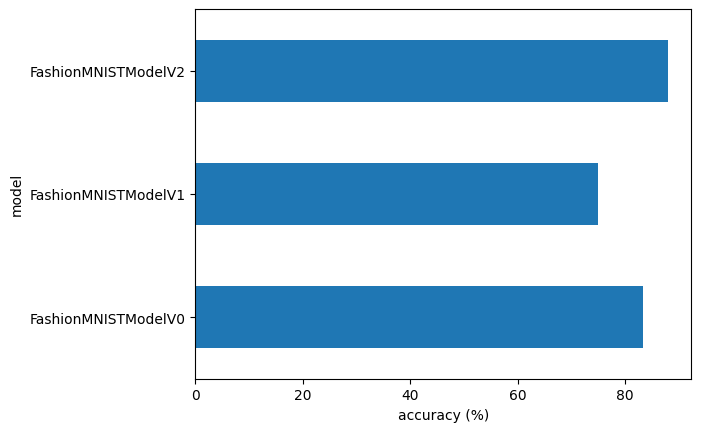

In [ ]:
# Visualize our model results
compare_results.set_index("model_name")["model_acc"].plot(kind="barh")
plt.xlabel("accuracy (%)")
plt.ylabel("model")

## 9. Make and evaluate random predictions with best model

In [ ]:
def make_predictions(model: torch.nn.Module,
                     data: list,
                     device: torch.device = device):
  pred_probs = []
  model.to(device)
  model.eval()
  with torch.inference_mode():
    for sample in data:
      # Prepare the sample (add a batch dimension and pass to target device)
      sample = torch.unsqueeze(sample, dim=0).to(device)

      # Forward pass (model outputs raw logits)
      pred_logit = model(sample)

      # Get prediction probabilities (logits -> prediction probability)
      pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)

      # Get pred_prob off the GPU for further calculations
      pred_probs.append(pred_prob.cpu())

  # Stack the pred_probs to turn list into a tensor
  return torch.stack(pred_probs)

In [ ]:
import random
random.seed(42)
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_data), k=9):
  test_samples.append(sample)
  test_labels.append(label)

# View the first sample shape
test_samples[0].shape

torch.Size([1, 28, 28])

Text(0.5, 1.0, 'Sandal')

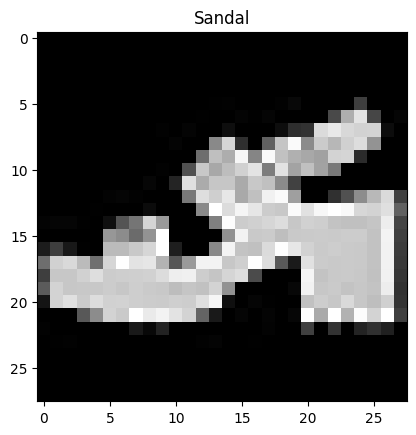

In [ ]:
plt.imshow(test_samples[0].squeeze(), cmap="gray")
plt.title(class_names[test_labels[0]])

In [ ]:
# Make predictions
pred_probs = make_predictions(model=model_2,
                              data=test_samples)

# View first two prediction probabilities
pred_probs[:2]

tensor([[2.8846e-07, 5.8427e-08, 1.0407e-07, 1.2185e-06, 6.6755e-08, 9.9987e-01,
         7.0603e-07, 2.7576e-05, 3.1653e-05, 7.2814e-05],
        [5.6971e-02, 6.9445e-01, 9.5664e-04, 1.1693e-01, 1.0671e-02, 1.4998e-04,
         1.1889e-01, 3.2476e-04, 5.8680e-04, 7.6648e-05]])

In [ ]:
# Convert prediction probabilities to labels
pred_classes = pred_probs.argmax(dim=1)
pred_classes

tensor([5, 1, 7, 4, 3, 0, 4, 7, 1])

In [ ]:
test_labels

[5, 1, 7, 4, 3, 0, 4, 7, 1]

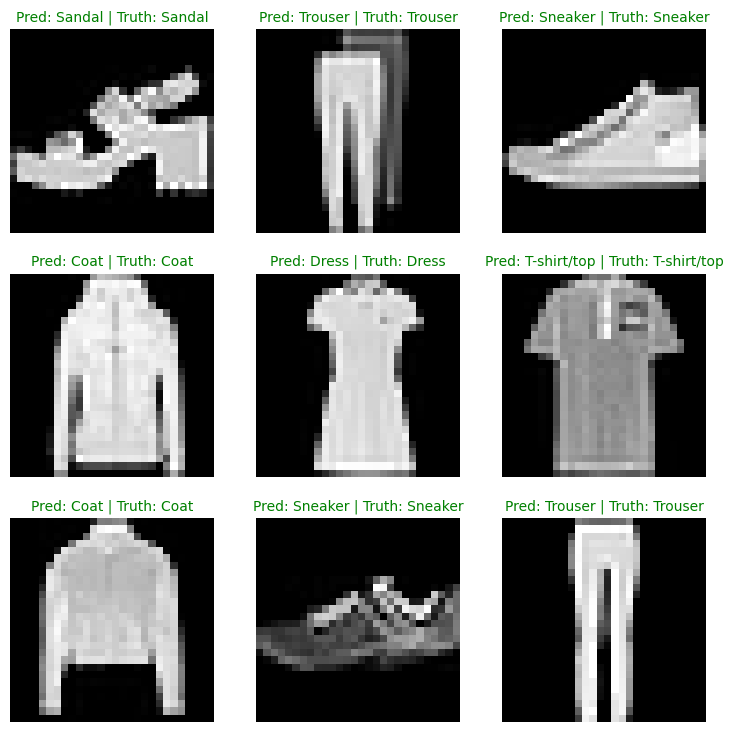

In [ ]:
# Plot predictions
plt.figure(figsize=(9, 9))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):
  # Create subplot
  plt.subplot(nrows, ncols, i+1)

  # PLot the target image
  plt.imshow(sample.squeeze(), cmap="gray")

  # Find the prediction (in text form e.g. "Sandal")
  pred_label = class_names[pred_classes[i]]

  # Get the truth label (in text form)
  truth_label = class_names[test_labels[i]]

  # Create a title for the plot
  title_text = f"Pred: {pred_label} | Truth: {truth_label}"

  # Check for equality between pred and truth and change color of title text
  if pred_label == truth_label:
    plt.title(title_text, fontsize=10, c="g")
  else:
    plt.title(title_text, fontsize=10, c="r")

  plt.axis(False)

## 10. Making a confusion matrix for further prediction evaluation
1. Make predictions with our trained model on the test datset
2. Make a confusion matrix `torchmetrics.Confusionmatrix`
3. Plot the confusion matrix using `mlxtend.plotting.plot_confusion_matrix()`

In [ ]:
# Import tqdm.auto
from tqdm.auto import tqdm

# 1. Make predcitions with trained model
y_preds = []

model_2.eval()

with torch.inference_mode():
  for X, y in tqdm(test_dataloader, desc="Making predictions..."):
    # Send data and labels to the target device
    X, y = X.to(device), y.to(device)
    # Do the forward pass
    y_logit = model_2(X)
    # Turn predictions from logits -> predictions probabilities -> prediction labels
    y_pred = torch.softmax(y_logit.squeeze(), dim=0).argmax(dim=1)
    # Put predictions on CPU for evaluation
    y_preds.append(y_pred.cpu())

# Concatenate list of predictions into a tensor
y_pred_tensor = torch.cat(y_preds)
y_pred_tensor[:10]

Making predictions...:   0%|          | 0/313 [00:00<?, ?it/s]

tensor([9, 2, 1, 1, 6, 1, 4, 6, 5, 7])

In [ ]:
# See if required packages arte installed and if not, install them...
try:
  import torchmetrics, mlxtend
  print(f"mlxtend version: {mlxtend.__version__}")
  assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend version shopuld be 0.19.0 or higher"
except:
  !pip install -q torchmetrics -U mlxtend
  import torchmetrics, mlxtend
  print(f"mlxtend version: {mlxtend.__version__}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 122.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 89.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 837.1 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 100.4 MB/s eta 0:00:00
mlxtend version: 0.23.4


In [ ]:
import mlxtend

In [ ]:
mlxtend.__version__

'0.23.4'

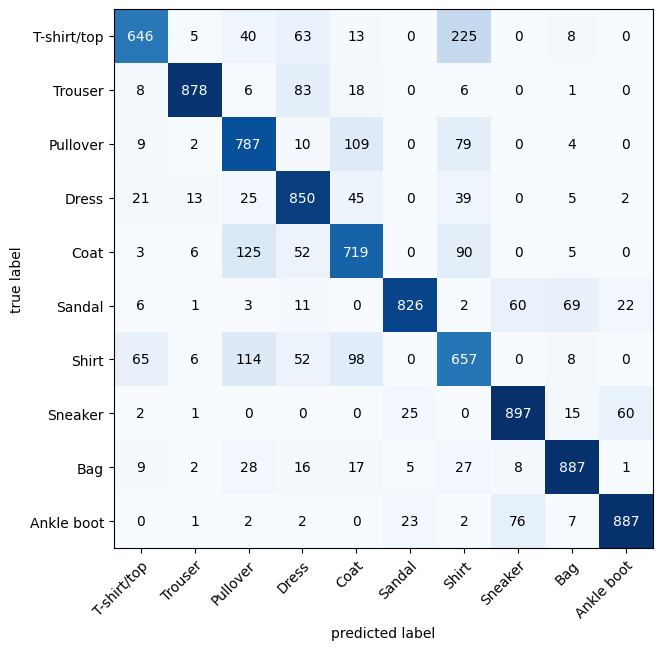

In [ ]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# 2. Setup confusion matrix instance and compare predictions to targets
confmat = ConfusionMatrix(task="multiclass", num_classes=len(class_names))
confmat_tensor = confmat(preds=y_pred_tensor,
                         target=test_data.targets)

# 3. Plot the confusion matric
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(),
    class_names=class_names,
    figsize=(10, 7)
)

## 11. Save and load best performing model

In [ ]:
from pathlib import Path

# Create model directory path
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True,
                 exist_ok=True)

# Create model save
MODEL_NAME = "03_pytorch_computer_vision_model_2.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save the model staet dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_2.state_dict(),
           f=MODEL_SAVE_PATH)

Saving model to: models/03_pytorch_computer_vision_model_2.pth


In [ ]:
# Create a new instance
torch.manual_seed(42)

loaded_model_2 = FashionMNISTModelV2(input_shape=1,
                                     hidden_units=10,
                                     output_shape=len(class_names))

# Load in the saved state_dict()
loaded_model_2.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

# Send the model to target device
loaded_model_2.to(device)

FashionMNISTModelV2(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [ ]:
model_2_results

{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.32693716883659363,
 'model_acc': 87.96924920127796}

In [ ]:
# Evaluate loaded model
torch.manual_seed(42)

loaded_model_2_results = eval_model(model=loaded_model_2,
                                    data_loader=test_dataloader,
                                    loss_fn=loss_fn,
                                    accuracy_fn=accuracy_fn,
                                    device=device)

loaded_model_2_results

  0%|          | 0/313 [00:00<?, ?it/s]

{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.32693716883659363,
 'model_acc': 87.96924920127796}

In [ ]:
# Check if model results are close to each other
torch.isclose(torch.tensor(model_2_results["model_loss"]),
              torch.tensor(loaded_model_2_results["model_loss"]))

tensor(True)